In [1]:
### imports and notebook parameters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999
float_formatter = "{:,.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter}, linewidth = 300)
from scipy.optimize import linprog
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings(action='ignore', category=LinAlgWarning)
import math
from numpy.random import default_rng
rng = default_rng()
pd.set_option("max_colwidth", 250)

In [2]:
### non-class functions
# these are used throughout the two major class objects

# returns ab-coordinates for a generic concentric hexagonal array given a radius argument 
def hextoab(hexrad):
    ab_coords = []
    for a in range(-hexrad,hexrad+1,1):
        for b in range(-hexrad-min(a,0),hexrad-max(a,0)+1,1):
            ab_coords.append([a,b])
    #        print(f'({a},{b})')
    ab_coords = np.array(ab_coords)
    return ab_coords

# similar, but for a parallelogram
def hexparatoab(hexrad):
    ab_coords = []
    for a in range(-hexrad,hexrad+1,1):
        for b in range(-hexrad,hexrad+1,1):
            ab_coords.append([a,b])
    #        print(f'({a},{b})')
    ab_coords = np.array(ab_coords)
    return ab_coords

# linear transformations from ab-coordinates to xy and vice-versa
def Txy(T,a,b):
    return T @ np.array([a,b])
def Tab(Tinv,x,y):
    return Tinv @ np.array([x,y])

# standard matrix and inverse definition and calculation, for linear transformation above
T = np.array([[np.sqrt(3), np.sqrt(3)/2],[0,3/2]])
Tinv = np.linalg.inv(T)

# function that returns xy coordinates given ab coordinates
def abtoxy(ab_coords):
    xy_coords = []
    for i in range(len(ab_coords)):
        xy_coords.append(Txy(T, *ab_coords[i]))
    xy_coords = np.array(xy_coords)
    return xy_coords

# function that returns ab coordinate given xy coordinates
def xytoab(xy_coords):
    ab_coords = []
    for i in range(len(xy_coords)):
        ab_coords.append(Tab(Tinv, *xy_coords[i]))
    ab_coords = np.array(ab_coords)
    return ab_coords    

# returns a vector of length l and one entries at indices provided in array argument
def block(arr, l):
    return np.array([1 if i in arr else 0 for i in range(l)])

# pads a block (as defined in above function) with zeroes on either side corresponding
# to its place based on number of nodes (towers), channels, and the channel index argument
# the point in to return a nearly sparse row that can be added with other padded rows
def padblock(block, ch_idx, nodes, chans):
    return np.pad(block, pad_width=(nodes*ch_idx,nodes*(chans-ch_idx-1)))

# standard basis vector function
def sbv(idx, len):
    return np.array([1 if i == idx else 0 for i in range(len)])

# adds a series of padded blocks to construct a row. tool to construct constraint matrices
def row(padblocks):
    pbmatrix = np.vstack([padblocks])
    return pbmatrix.sum(axis=0)

# returns array of xy-coordinates generated from uniform distribution and specified range
def randomxy(points,xrange=5,yrange=5):
    return np.array(
        [[a,b] for (a,b) in zip(rng.random(points)*xrange, rng.random(points)*yrange)]
                    )

In [3]:
# main class for an optimization problem, based around the specific tower array
class towers():
    def __init__(self, xy_coords, channels, adj_k=2):
        self.xy_coords = xy_coords        
        self.ab_coords = xytoab(self.xy_coords)
        self.chans = channels
        self.nodes = len(self.xy_coords)
        # adj_k argument is min allowed diff between 2s towers, but
        # functionally k-1 is maximum disallowed diff
        self.adj_k=adj_k-1      
        self.iterations=0
        self.branch_count=0
        self.calc_dist_arr()
        self.calc_d_pairs()
        self.linprog_matrices()
        self.makeMasterDF()
        self.iters = []
        self.intsolns = []
        self.minintspan = []
        self.minintsoln = []
        self.openedbranches = []

    # function to compute distances between all towers    
    def calc_dist_arr(self):
        dist_arr = np.array([])
        for i in range(len(self.xy_coords)):
            u = self.xy_coords - self.xy_coords[i]
            udots = np.array([np.sqrt(np.dot(x,x)) for x in u])
            if i == 0:
                dist_arr = udots
            else:
                dist_arr = np.vstack([dist_arr, udots])
        self.dist_arr = dist_arr
    # function to compute constrained 2s and 4s dist pairs
    # the 2s constraint set is referred to as d1
    # the 4s constraint set is referred to as d2
    def calc_d_pairs(self):
        for i in range(self.dist_arr.shape[0]):
            v = self.dist_arr[i]
            d1 = [[i,j] for j in range(len(v)) if ((v[j] <= 2) & (v[j] > 0))]
            d2 = [[i,k] for k in range(len(v)) if ((v[k] <= 4) & (v[k] > 0))]
            if i == 0:
                self.d1_pairs = d1
                self.d2_pairs = d2
            else:
                self.d1_pairs = self.d1_pairs + d1
                self.d2_pairs = self.d2_pairs + d2
        for pair in self.d1_pairs:
            pair.sort()
        for pair in self.d2_pairs:
            pair.sort()
        self.d1_pairs.sort()
        self.d2_pairs.sort()
        self.d1_pairs = [self.d1_pairs[i] for i in range(len(self.d1_pairs)) 
                            if self.d1_pairs[i] not in self.d1_pairs[:i]]
        self.d2_pairs = [self.d2_pairs[i] for i in range(len(self.d2_pairs)) 
                            if self.d2_pairs[i] not in self.d2_pairs[:i]]

    # function to assemble linear program matrices, with flexibility for varied k
    def linprog_matrices(self):
        d2c = len(self.d2_pairs)
        d1c = len(self.d1_pairs)
        nodes = self.nodes
        chans = self.chans

        for i in range(chans):
            for j in range(len(self.d2_pairs)):
                if ((i == 0) & (j == 0)):
                    self.d2mtx = row([padblock(block(self.d2_pairs[j], nodes), i, nodes, chans)])
                else:
                    self.d2mtx = np.vstack([self.d2mtx,
                                    row([ padblock(block(self.d2_pairs[j], nodes), i, nodes, chans)])
                                    ])
        self.d1umtx = np.array([]) #sub-matrix for 2s constraints looking to higher channels
        self.d1dmtx = np.array([]) #sub-matrix for 2s constraints looking to lower channels
        if self.adj_k > 0:
            for i in range(chans):
                for j in range(len(self.d1_pairs)):
                    for k in range(1,self.adj_k+1):
                        if i + k < chans:
                            if len(self.d1umtx) == 0:
                                self.d1umtx = row([
                                    padblock(sbv(self.d1_pairs[j][0],nodes), i, nodes, chans),
                                    padblock(sbv(self.d1_pairs[j][1],nodes), i+k, nodes, chans)
                                                    ])
                            else:
                                self.d1umtx = np.vstack([self.d1umtx,
                                    row([
                                        padblock(sbv(self.d1_pairs[j][0],nodes), i, nodes, chans),
                                        padblock(sbv(self.d1_pairs[j][1],nodes), i+k, nodes, chans)
                                            ])
                                                        ])
            for i in range(chans):
                for j in range(len(self.d1_pairs)):
                    for k in range(1,self.adj_k+1):
                        if i - k >= 0:
                            if len(self.d1dmtx) == 0:
                                self.d1dmtx = row([
                                    padblock(sbv(self.d1_pairs[j][0],nodes), i, nodes, chans),
                                    padblock(sbv(self.d1_pairs[j][1],nodes), i-k, nodes, chans)
                                                    ])
                            else:
                                self.d1dmtx = np.vstack([self.d1dmtx,
                                    row([
                                        padblock(sbv(self.d1_pairs[j][0],nodes), i, nodes, chans),
                                        padblock(sbv(self.d1_pairs[j][1],nodes), i-k, nodes, chans)
                                            ])
                                                        ])
        for i in range(nodes):
            if i == 0:
                eq = np.reshape([sbv(i,nodes)] * chans, (1, nodes*chans))
            else:
                eq = np.vstack([eq, np.reshape([sbv(i,nodes)] * chans, (1, nodes*chans))])
        if self.adj_k > 0:
            self.Aub = np.vstack([self.d2mtx, self.d1umtx, self.d1dmtx])
        else:
            self.Aub = self.d2mtx
        self.eq = eq
        self.bub = np.ones(len(self.Aub))
        self.c = np.array([(nodes+1) ** ((i // nodes)) for i in range(chans*nodes)])

    # function to make a DataFrame (really just a single row) recording key information
    def makeMasterDF(self):
        self.dfcols = [ 'branch coords',
                        'lineage',
                        'generation',
                        'gen counter',
                        'children',
                        'span',
                        'obj function', 
                        'open chans',
                        'open nodes',
                        'closed nodes',
                        'num children',
                        'num open chans',
                        'num open nodes',
                        'num closed nodes',
                        'status',
                        'ch assgnmts']
        self.masterDF = pd.DataFrame(columns=self.dfcols)

    # function that returns a branch object for a given fork_arr, 
    # which is the set of integer channel constraints
    def branch(self, fork_arr):
        return branch(self.Aub, self.eq, self.bub, self.c, self.nodes, 
                        self.chans, self.dfcols, self.lineages, fork_arr)
    
    # generates initial set of branches for a new towers class object
    def plant(self):
        self.lineages = []
        branch = self.branch([])
        newdf = branch.df
        self.masterDF = pd.concat([self.masterDF, newdf])

        gen = [int(a) for a in list(self.masterDF['generation'])]
        stat = list(self.masterDF['status'])
        stat_int = [1 if a == 'open' else 0 for a in stat]
        adj_gen = list(np.array(gen) * np.array(stat_int))
        ctr = [len([x for x in adj_gen[:y+1] if ((x == gen[y]) & (adj_gen[y] > 0))])
                     for y in range(len(gen))]
        self.masterDF['gen counter'] = ctr
        self.lineages = [a for a in branch.children]
        self.linnums = list(range(len(self.lineages)))

    # prevents failure for some edge cases where apparently feasible constraints are not
    # the set of feasible branches is given by non-zero values in variable entries,
    # but rare low values can be "hoaxes"
    def trybranch(self, fork_arr):
        try:
            return self.branch(fork_arr).df
        except TypeError:
            pass
    
    # function to remove duplicates for a list, refers to self
    def remove_dupes(self, tup):
        counts = [len([x for x in tup[:y+1] if set(x) == set(tup[y])]) for y in range(len(tup))]
        return tuple(tup[i] for i in range(len(tup)) if counts[i] <=1 )

    # function to remove elements from tup1 (tuple 1) that are in tup2 (tuple 2).
    # the set method only works on coordinate tuples, not lists of lists
    def screen_dupes(self, tup1, tup2):
        counts = [len([x for x in range(len(tup2)) if set(tup1[y]) == set(tup2[x])])
                     for y in range(len(tup1))]
        return list(tup1[i] for i in range(len(tup1)) if counts[i] == 0 )

    # main branching function. identifies branch path, checks for already checked forks, 
    # calls branch function defined above, and runs back-end statistics
    def grow(self, type='drill', lin=0):
        if type == 'drill':
            self.maxgen = self.masterDF['generation'].loc[self.masterDF['status'] == 'open'].max()
            rawchildren = list(self.masterDF['children'].loc[
                (self.masterDF['status'] == 'open') & 
                (self.masterDF['gen counter'] == 1) & 
                (self.masterDF['generation'] == self.maxgen)])
            self.masterDF.loc[
                ((self.masterDF['status'] == 'open') & 
                 (self.masterDF['gen counter'] == 1) & 
                 (self.masterDF['generation'] == self.maxgen)), ['status']] = 'closed'
        if type == 'drill_lin':
            self.maxgen = self.masterDF['generation'].loc[
                (self.masterDF['status'] == 'open') & 
                (self.masterDF['lineage'] == lin)].max()
            mingenctr = self.masterDF['gen counter'].loc[
                (self.masterDF['status'] == 'open') & 
                (self.masterDF['lineage'] == lin) & 
                (self.masterDF['generation'] == self.maxgen)].max()
            rawchildren = list(self.masterDF['children'].loc[
                (self.masterDF['status'] == 'open') & 
                (self.masterDF['gen counter'] == mingenctr) & 
                (self.masterDF['generation'] == self.maxgen)])
            self.masterDF.loc[
                ((self.masterDF['status'] == 'open') &
                 (self.masterDF['gen counter'] == mingenctr) &
                (self.masterDF['generation'] == self.maxgen)), ['status']] = 'closed'
        if type == 'maxgen_min_obj':
            self.maxgen = self.masterDF['generation'].loc[self.masterDF['status'] == 'open'].max()
            self.min_obj_open_maxgen = self.masterDF['obj function'].loc[
                (self.masterDF['status'] == 'open') & 
                (self.masterDF['generation'] == self.maxgen)].min()
            rawchildren = list(self.masterDF['children'].loc[
                ((self.masterDF['generation'] == self.maxgen) &
                 (self.masterDF['obj function'] == self.min_obj_open_maxgen))])
            self.masterDF.loc[
                ((self.masterDF['generation'] == self.maxgen) &
                 (self.masterDF['obj function'] == self.min_obj_open_maxgen)), ['status']] = 'closed'

        self.flatlist = []
        for j in rawchildren:
            self.flatlist = self.flatlist + j

        flat_tuple = list(tuple(tuple(b) for b in a) for a in self.flatlist)
        flat_tuple = self.remove_dupes(flat_tuple)
        branch_coords_list =  list(self.masterDF['branch coords'].loc[
            (self.masterDF['generation'] >= 3)])
        branch_coords_tuple = list(tuple(tuple(b) for b in a) for a in branch_coords_list)
        screened_flat_tuple = self.screen_dupes(flat_tuple, branch_coords_tuple)
        screened_flatlist = list(list(list(b) for b in a) for a in screened_flat_tuple)
        self.flatlist = screened_flatlist

        self.dfarr = [self.masterDF] + [self.trybranch(i) for i in self.flatlist]
        self.masterDF = pd.concat(self.dfarr)
        self.masterDF.reset_index(inplace=True)
        self.masterDF.drop(columns=['index'], inplace=True)

        gen = [int(a) for a in list(self.masterDF['generation'])]
        stat = list(self.masterDF['status'])
        stat_int = [1 if a == 'open' else 0 for a in stat]
        adj_gen = list(np.array(gen) * np.array(stat_int))
        ctr = [len([x for x in adj_gen[:y+1] if ((x == gen[y]) & 
            (adj_gen[y] > 0))]) for y in range(len(gen))]
        self.masterDF['gen counter'] = ctr
        self.maxgen = self.masterDF['generation'].loc[self.masterDF['status'] == 'open'].max()
        self.min_int_span = self.masterDF['span'].loc[self.masterDF['num open nodes'] == 0].min()
        self.min_int_obj = self.masterDF['obj function'].loc[
            self.masterDF['num open nodes'] == 0].min()      
        self.iterations += 1
        self.branch_count += len(self.flatlist)

    # identifies and eliminates inferior branches
    def prune(self):
        self.masterDF.loc[((self.masterDF['status'] == 'open') & 
            (self.masterDF['num open nodes'] == 0)), ['status']] = 'closed'
        self.masterDF.loc[((self.masterDF['status'] == 'open') & 
            (self.masterDF['span'] >= self.min_int_span)), ['status']] = 'closed'
        self.masterDF.loc[((self.masterDF['status'] == 'open') & 
            (self.masterDF['obj function'] >= self.min_int_obj)), ['status']] = 'closed'
        self.masterDF = self.masterDF.loc[((self.masterDF['status'] == 'open') | 
            (self.masterDF['num open nodes'] == 0))].copy(deep=True)
        gen = [int(a) for a in list(self.masterDF['generation'])]
        stat = list(self.masterDF['status'])
        stat_int = [1 if a == 'open' else 0 for a in stat]
        adj_gen = list(np.array(gen) * np.array(stat_int))
        ctr = [len([x for x in adj_gen[:y+1] if ((x == gen[y]) & 
            (adj_gen[y] > 0))]) for y in range(len(gen))]
        self.masterDF['gen counter'] = ctr
        self.maxgen = self.masterDF['generation'].loc[self.masterDF['status'] == 'open'].max()
        self.min_obj_open_maxgen = self.masterDF['obj function'].loc[
            (self.masterDF['status'] == 'open') & 
            (self.masterDF['generation'] == self.maxgen)].min()  

    # a reset function for the towers object. wipes all branches 
    # (by erasing master DataFrame, which is the branch ledger), and starts over
    def replant(self):
        self.makeMasterDF()
        self.iterations=0
        self.plant()

    # focused drill down branching routine
    def bnb_drill(self, iters):
        for i in range(iters):
            self.grow()
            self.prune()
            self.iters.append(self.iterations)
            self.intsolns.append(len(self.masterDF.loc[self.masterDF['num open nodes'] == 0]))
            self.minintspan.append(self.min_int_span)
            self.minintsoln.append(self.min_int_obj)
            self.openedbranches.append(self.branch_count)
        self.makeResultsDF()
        self.get_ch_assgnmts_DF()
        if len(self.ch_assgnmts_DF) > 0:
            self.ch_assgnmt = list(self.masterDF['ch assgnmts'].loc[
                (self.masterDF['num open nodes'] == 0) & 
                (self.masterDF['span'] == self.min_int_span)])[-1]
        else:
            self.ch_assgnmt = []

    # drill down routine with cycles through all lineages
    def bnb_lin_drill_cycle(self, iters, cycles=1):
        for k in range(cycles):
            for j in self.linnums:
                for i in range(iters):
                    self.grow(type='drill_lin', lin=j)
                    self.prune()
                    self.iters.append(self.iterations)
                    self.intsolns.append(len(self.masterDF.loc[
                        self.masterDF['num open nodes'] == 0]))
                    self.minintspan.append(self.min_int_span)
                    self.minintsoln.append(self.min_int_obj)
                    self.openedbranches.append(self.branch_count)
        self.makeResultsDF()
        self.get_ch_assgnmts_DF()
        if len(self.ch_assgnmts_DF) > 0:
            self.ch_assgnmt = list(self.masterDF['ch assgnmts'].loc[
                (self.masterDF['num open nodes'] == 0) & 
                (self.masterDF['span'] == self.min_int_span)])[-1]
        else:
            self.ch_assgnmt = []

    # branching routine that selects the minimum objective function val from newest generation 
    # (in theory most promising branch)
    def bnb_min_obj_max_gen(self, iters):
        for i in range(iters):
            self.grow('maxgen_min_obj')
            self.prune()
            self.iters.append(self.iterations)
            self.intsolns.append(len(self.masterDF.loc[self.masterDF['num open nodes'] == 0]))
            self.minintspan.append(self.min_int_span)
            self.minintsoln.append(self.min_int_obj)
            self.openedbranches.append(self.branch_count)
        self.makeResultsDF()
        self.get_ch_assgnmts_DF()
        if len(self.ch_assgnmts_DF) > 0:
            self.ch_assgnmt = list(self.masterDF['ch assgnmts'].loc[
                (self.masterDF['num open nodes'] == 0) & 
                (self.masterDF['span'] == self.min_int_span)])[-1]
        else:
            self.ch_assgnmt = []

    # make DataFrame tabulating performance results by branching iteration
    def makeResultsDF(self):
        self.resdfdata = { 'iters' : self.iters,
                        'integer solns' : self.intsolns,
                        'min integer span' : self.minintspan,
                        'min integer obj' : self.minintsoln,
                        'opened branches' : self.openedbranches
                        }
        self.resultsdf = pd.DataFrame(self.resdfdata, index = range(len(self.iters)))

    # finds list of optimal channel assignments from list of integer solutions    
    def get_ch_assgnmts_DF(self):
        self.ch_assgnmts_DF = self.masterDF[['span','obj function','ch assgnmts']].loc[
            (self.masterDF['num open nodes'] == 0) & 
            (self.masterDF['span'] == self.min_int_span)].copy(deep=True)

    # function to add channel number next to point on graphs
    def ann_pt_ch(self,x,y,ch):
        s = f"({ch+1:.0f})"
        self.ax.annotate(s,xy=(x,y),xytext=(-5,-15),textcoords='offset points')

    # function to add coordinates next to point on graphs    
    def ann_pt(self,x,y,dec=0):
        s = f"({x:.{dec}f},{y:.{dec}f})"
        self.ax.annotate(s,xy=(x,y),xytext=(-5,-15),textcoords='offset points')

    # function to generate plot with channel assignment nums
    def plot_channels(self, abax=False, square=True, buffer=0.5, fig_size=(3,3)):
        if square == True:
            x_min = math.floor(min(self.xy_coords[:,0].min(),self.xy_coords[:,1].min())) - buffer
            x_max = math.ceil(max(self.xy_coords[:,0].max(),self.xy_coords[:,1].max())) + buffer
            y_min = x_min
            y_max = x_max
        else:
            x_min = math.floor(self.xy_coords[:,0].min()) - buffer
            x_max = math.ceil(self.xy_coords[:,0].max()) + buffer
            y_min = math.floor(self.xy_coords[:,1].min()) - buffer
            y_max = math.ceil(self.xy_coords[:,1].max()) + buffer
        self.plot=plt.figure(figsize=fig_size)
        self.ax = plt.axes()
        x = np.linspace(x_min,x_max,500)
        if abax == True:
            self.ax.plot(x, 0 * x, label="a-axis")
            self.ax.plot(x, np.sqrt(3) * x, label = "b-axis")
            self.ax.legend()
        for i in range(len(self.xy_coords)):
            self.ax.scatter(self.xy_coords[i,0], self.xy_coords[i,1],s=50,color="blue")
        self.ax.set_xlim(xmin=x_min, xmax=x_max)
        self.ax.set_ylim(ymin=y_min, ymax=y_max)

        for i in self.ch_assgnmt:
            self.ann_pt_ch(self.xy_coords[i[0],0],self.xy_coords[i[0],1],i[1])

    # function to generate plot with xy points and labels
    def plot_xy_points(self, abax=False, square=True, buffer=0.5, fig_size=(3,3)):
        if square == True:
            x_min = math.floor(min(self.xy_coords[:,0].min(),self.xy_coords[:,1].min())) - buffer
            x_max = math.ceil(max(self.xy_coords[:,0].max(),self.xy_coords[:,1].max())) + buffer
            y_min = x_min
            y_max = x_max
        else:
            x_min = math.floor(self.xy_coords[:,0].min()) - buffer
            x_max = math.ceil(self.xy_coords[:,0].max()) + buffer
            y_min = math.floor(self.xy_coords[:,1].min()) - buffer
            y_max = math.ceil(self.xy_coords[:,1].max()) + buffer

        self.plot=plt.figure(figsize=fig_size)
        self.ax = plt.axes()
        x = np.linspace(x_min,x_max,500)
        if abax == True:
            self.ax.plot(x, 0 * x, label="a-axis")
            self.ax.plot(x, np.sqrt(3) * x, label = "b-axis")
            self.ax.legend()
        for i in range(len(self.xy_coords)):
            self.ax.scatter(self.xy_coords[i,0], self.xy_coords[i,1],s=50,color="blue")
        self.ax.set_xlim(xmin=x_min, xmax=x_max)
        self.ax.set_ylim(ymin=y_min, ymax=y_max)
        for i in self.xy_coords:
            self.ann_pt(i[0],i[1],dec=2)

    # function to generate plot with ab points and labels
    def plot_ab_points(self, square=True, buffer=0.5, fig_size=(3,3)):
        if square == True:
            x_min = math.floor(min(self.ab_coords[:,0].min(),self.ab_coords[:,1].min())) - buffer
            x_max = math.ceil(max(self.ab_coords[:,0].max(),self.ab_coords[:,1].max())) + buffer
            y_min = x_min
            y_max = x_max
        else:
            x_min = math.floor(self.ab_coords[:,0].min()) - buffer
            x_max = math.ceil(self.ab_coords[:,0].max()) + buffer
            y_min = math.floor(self.ab_coords[:,1].min()) - buffer
            y_max = math.ceil(self.ab_coords[:,1].max()) + buffer

        self.plot=plt.figure(figsize=fig_size)
        self.ax = plt.axes()
        x = np.linspace(x_min,x_max,500)
        self.ax.plot(x, 0 * x, label="a-axis")
        self.ax.vlines(0, ymin=y_min, ymax=y_max, color = "orange", label = "b-axis")
        self.ax.legend()
        for i in range(len(self.ab_coords)):
            self.ax.scatter(self.ab_coords[i,0], self.ab_coords[i,1],s=50,color="blue")
        self.ax.set_xlim(xmin=x_min, xmax=x_max)
        self.ax.set_ylim(ymin=y_min, ymax=y_max)
        for i in self.ab_coords:
            self.ann_pt(i[0],i[1],dec=0)

In [4]:
# branch class data structure. this contains information pertaining to a specific branch
# which is a distinct linear program with some degree of relaxation
class branch():
    def __init__(self, Aub, eq, bub, c, nodes, chans, dfcols, lineages, fork_arr, int_thres = 5e-10):
        self.Aub = Aub
        self.eq = eq
        self.bub = bub
        self.c = c
        self.nodes = nodes
        self.chans = chans
        self.dfcols = dfcols
        self.lineages = lineages
        forkarr = fork_arr

        if len(forkarr) > 0:
            self.Aeq = np.vstack([
                                  self.eq,
                                  [padblock(sbv(forkarr[i][0], self.nodes), 
                                    forkarr[i][1], self.nodes, self.chans) 
                                    for i in range(len(forkarr))]
                                  ])
        else:
            self.Aeq = self.eq
        self.beq = np.ones(len(self.Aeq))
        self.result = linprog(c=self.c, A_eq=self.Aeq, b_eq=self.beq, A_ub=self.Aub, 
            b_ub=self.bub, bounds=(0,1), method='highs')
        idx = [i if np.round(self.result.x,2)[i] > 0 else 0 for i in range(len(self.result.x))]
        self.rsltmtx = self.result.x.reshape(self.chans,self.nodes)
        self.span = (max(idx)) // self.nodes + 1
        self.nodes_closed = [i for i in range(self.rsltmtx.shape[1]) if 
            all(abs(self.rsltmtx[:,i]) % 1 < int_thres)]
        self.nodes_open = [i for i in range(self.rsltmtx.shape[1]) if 
            any(abs(self.rsltmtx[:,i]) % 1 >= int_thres)]
        self.chans_closed = [i for i in range(self.rsltmtx.shape[0]) if 
            all(abs(self.rsltmtx[i,:]) % 1 < int_thres)]
        self.chans_open = [i for i in range(self.rsltmtx.shape[0]) if 
            any(abs(self.rsltmtx[i,:]) % 1 >= int_thres)]
        
        self.chan_opennodes = []
        for i in self.chans_open:
            self.chan_opennodes.append([j for j in range(self.rsltmtx.shape[1]) if 
                abs(self.rsltmtx[i,j] % 1 >= int_thres)])

        self.children = []
        if len(self.chans_open) > 0:
            for j in self.chan_opennodes[0]:
                self.children.append([j, self.chans_open[0]])
        else:
            self.children = []

        if len(forkarr) > 0:
            self.children = [forkarr + [i] for i in self.children]
        else:
            self.children = [[i] for i in self.children]

        if len(forkarr) > 0:
            self.forkarr = forkarr
            self.parent = self.forkarr[:-1]
            self.linarr = [self.forkarr[0]]
            self.lineage = int(self.lineages.index(self.linarr))
        else:
            self.forkarr = []
            self.parent = np.nan
            self.linarr = []
            self.lineage = np.nan
        self.status = 'open'
        self.ch_assgnmts = [[i,j] for i in self.nodes_closed for 
            j in range(len(self.rsltmtx[:,i])) if ((self.rsltmtx[:,i][j] + int_thres) // 1) == 1]

        self.makeBnBdf()

    def makeBnBdf(self):
        self.dfdata = { 'branch coords' : [self.forkarr],
                        'lineage' : self.lineage,
                        'generation' : len(self.forkarr) + 1,
                        'gen counter' : 0,
                        'children' : [self.children],
                        'span' : self.span,
                        'obj function' : self.result.fun,
                        'open chans' : [self.chans_open],
                        'open nodes' : [self.nodes_open],
                        'closed nodes' : [self.nodes_closed],
                        'num children' : len(self.children),
                        'num open chans' : len(self.chans_open),
                        'num open nodes' : len(self.nodes_open),
                        'num closed nodes' : len(self.nodes_closed),
                        'status' : self.status,
                        'ch assgnmts' : [self.ch_assgnmts]
                        }
        self.df = pd.DataFrame(self.dfdata, index = [0])

min span: 3


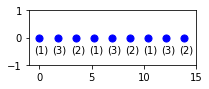

In [5]:
nineline = np.array([[j,0] for j in range(9)])
line_k1 = towers(abtoxy(nineline), 20, adj_k=1)
line_k1.plant()
line_k1.grow()
line_k1.bnb_drill(1000)
print(f'min span: {line_k1.min_int_span}')
line_k1.plot_channels(abax=False,square=False,buffer=1,fig_size=(3,1))

min span: 5


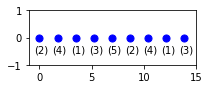

In [6]:
line_k2 = towers(abtoxy(nineline), 20, adj_k=2)
line_k2.plant()
line_k2.grow()
line_k2.bnb_drill(1000)
print(f'min span: {line_k2.min_int_span}')
line_k2.plot_channels(abax=False,square=False,buffer=1,fig_size=(3,1))

min span: 6


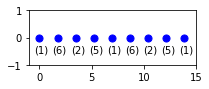

In [7]:
line_k3 = towers(abtoxy(nineline), 20, adj_k=3)
line_k3.plant()
line_k3.grow()
line_k3.bnb_drill(1000)
print(f'min span: {line_k3.min_int_span}')
line_k3.plot_channels(abax=False,square=False,buffer=1,fig_size=(3,1))

min span: 7


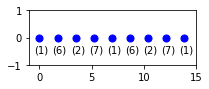

In [8]:
line_k4 = towers(abtoxy(nineline), 20, adj_k=4)
line_k4.plant()
line_k4.grow()
line_k4.bnb_drill(1000)
print(f'min span: {line_k4.min_int_span}')
line_k4.plot_channels(abax=False,square=False,buffer=1,fig_size=(3,1))

min span: 7


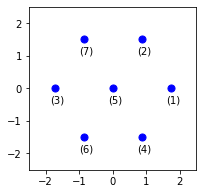

In [9]:
hex1_k1 = towers(abtoxy(hextoab(1)), 20, adj_k=1)
hex1_k1.plant()
hex1_k1.grow()
hex1_k1.bnb_lin_drill_cycle(50, cycles=1)
print(f'min span: {hex1_k1.min_int_span}')
hex1_k1.plot_channels()

min span: 8


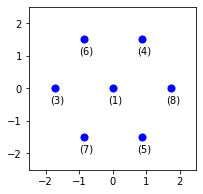

In [10]:
hex1_k2 = towers(abtoxy(hextoab(1)), 20, adj_k=2)
hex1_k2.plant()
hex1_k2.grow()
hex1_k2.bnb_lin_drill_cycle(50, cycles=1)
print(f'min span: {hex1_k2.min_int_span}')
hex1_k2.plot_channels()

min span: 10


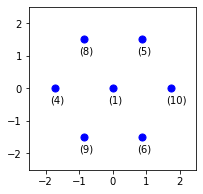

In [11]:
hex1_k3 = towers(abtoxy(hextoab(1)), 20, adj_k=3)
hex1_k3.plant()
hex1_k3.grow()
hex1_k3.bnb_lin_drill_cycle(50, cycles=1)
print(f'min span: {hex1_k3.min_int_span}')
hex1_k3.plot_channels()

min span: 12


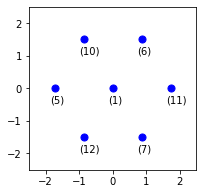

In [12]:
hex1_k4 = towers(abtoxy(hextoab(1)), 20, adj_k=4)
hex1_k4.plant()
hex1_k4.grow()
hex1_k4.bnb_lin_drill_cycle(50, cycles=1)
print(f'min span: {hex1_k4.min_int_span}')
hex1_k4.plot_channels()

min span: 10


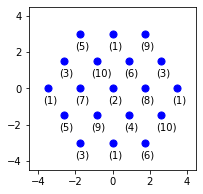

In [13]:
hex2_k2_drill = towers(abtoxy(hextoab(2)), 20, adj_k=2)
hex2_k2_drill.plant()
hex2_k2_drill.grow()
hex2_k2_drill.bnb_drill(1000)
print(f'min span: {hex2_k2_drill.min_int_span}')
hex2_k2_drill.plot_channels()

min span: 11


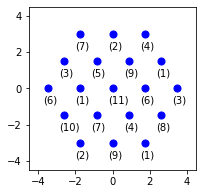

In [14]:
hex2_k2_cycles_1000tot = towers(abtoxy(hextoab(2)), 20, adj_k=2)
hex2_k2_cycles_1000tot.plant()
hex2_k2_cycles_1000tot.grow()
hex2_k2_cycles_1000tot.bnb_lin_drill_cycle(53)
print(f'min span: {hex2_k2_cycles_1000tot.min_int_span}')
hex2_k2_cycles_1000tot.plot_channels()

min span: 11


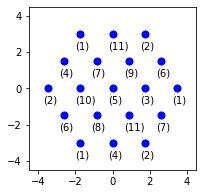

In [15]:
hex2_k2_min_obj_max_gen = towers(abtoxy(hextoab(2)), 20, adj_k=2)
hex2_k2_min_obj_max_gen.plant()
hex2_k2_min_obj_max_gen.grow()
hex2_k2_min_obj_max_gen.bnb_min_obj_max_gen(1000)
print(f'min span: {hex2_k2_min_obj_max_gen.min_int_span}')
hex2_k2_min_obj_max_gen.plot_channels()

Text(0.5, 0, 'iteration')

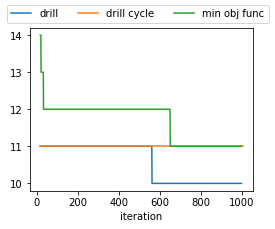

In [54]:
pl1 = plt.figure(figsize=(4,3))
ax1 = plt.axes()
ax1.plot(hex2_k2_drill.resultsdf['min integer span'],label="drill")
ax1.plot(hex2_k2_cycles_1000tot.resultsdf['min integer span'],label="drill cycle")
ax1.plot(hex2_k2_min_obj_max_gen.resultsdf['min integer span'],label="min obj func")
pl1.legend(loc='upper center',ncol=3)
ax1.set_xlabel('iteration')

Text(0.5, 0, 'iteration')

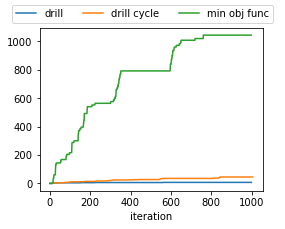

In [52]:
pl2 = plt.figure(figsize=(4,3))
ax2 = plt.axes()
ax2.plot(hex2_k2_drill.resultsdf['integer solns'],label="drill")
ax2.plot(hex2_k2_cycles_1000tot.resultsdf['integer solns'],label="drill cycle")
ax2.plot(hex2_k2_min_obj_max_gen.resultsdf['integer solns'],label="min obj func")
pl2.legend(loc='upper center',ncol=3)
ax2.set_xlabel('iteration')

Text(0.5, 0, 'iteration')

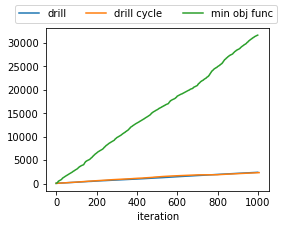

In [55]:
pl3 = plt.figure(figsize=(4,3))
ax3 = plt.axes()
ax3.plot(hex2_k2_drill.resultsdf['opened branches'],label="drill")
ax3.plot(hex2_k2_cycles_1000tot.resultsdf['opened branches'],label="drill cycle")
ax3.plot(hex2_k2_min_obj_max_gen.resultsdf['opened branches'],label="min obj func")
pl3.legend(loc='upper center',ncol=3)
ax3.set_xlabel('iteration')

In [67]:
hex2_k2_drill.resultsdf[(hex2_k2_drill.resultsdf['iters']==500) | 
    (hex2_k2_drill.resultsdf['iters']==1000)]

,iters,integer solns,min integer span,min integer obj,opened branches
498,500,6,11.0,1.077901e+13,1194
998,1000,7,10.0,1.076551e+12,2390


In [69]:
hex2_k2_cycles_1000tot.resultsdf[(hex2_k2_cycles_1000tot.resultsdf['iters']==500) | 
    (hex2_k2_cycles_1000tot.resultsdf['iters']==1000)]

,iters,integer solns,min integer span,min integer obj,opened branches
498,500,27,11.0,1.077901e+13,1404
998,1000,45,11.0,1.077895e+13,2317


In [70]:
hex2_k2_min_obj_max_gen.resultsdf[(hex2_k2_min_obj_max_gen.resultsdf['iters']==500) | 
    (hex2_k2_min_obj_max_gen.resultsdf['iters']==1000)]

,iters,integer solns,min integer span,min integer obj,opened branches
498,500,792,12.0,2.053658e+14,15666
998,1000,1044,11.0,2.101901e+13,31590


<AxesSubplot:>

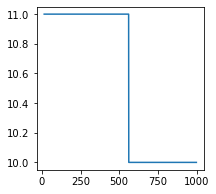

In [16]:
hex2_k2_drill.resultsdf['min integer span'].plot(figsize=(3,3))

<AxesSubplot:>

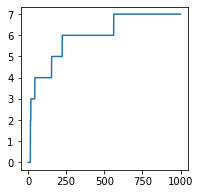

In [17]:
hex2_k2_drill.resultsdf['integer solns'].plot(figsize=(3,3))

<AxesSubplot:>

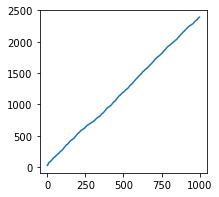

In [18]:
hex2_k2_drill.resultsdf['opened branches'].plot(figsize=(3,3))

<AxesSubplot:>

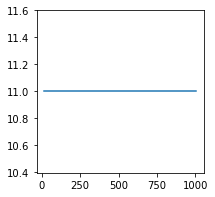

In [19]:
hex2_k2_cycles_1000tot.resultsdf['min integer span'].plot(figsize=(3,3))

<AxesSubplot:>

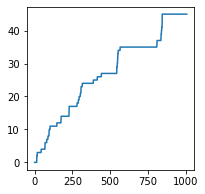

In [20]:
hex2_k2_cycles_1000tot.resultsdf['integer solns'].plot(figsize=(3,3))

<AxesSubplot:>

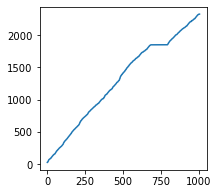

In [21]:
hex2_k2_cycles_1000tot.resultsdf['opened branches'].plot(figsize=(3,3))

min span: 8


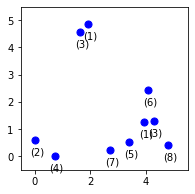

In [25]:
random10_5_arr = randomxy(10,5,5)
random10_5_drill = towers(random10_5_arr, 25, adj_k=2)
random10_5_drill.plant()
random10_5_drill.grow()
random10_5_drill.bnb_drill(1000)
print(f'min span: {random10_5_drill.min_int_span}')
random10_5_drill.plot_channels()

min span: 8


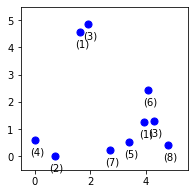

In [26]:
random10_5_cycles = towers(random10_5_arr, 25, adj_k=2)
random10_5_cycles.plant()
random10_5_cycles.grow()
random10_5_cycles.bnb_lin_drill_cycle(100,cycles=1)
print(f'min span: {random10_5_cycles.min_int_span}')
random10_5_cycles.plot_channels()

min span: 10


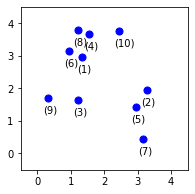

In [27]:
random10_4_arr = randomxy(10,4,4)
random10_4_drill = towers(random10_4_arr, 25, adj_k=2)
random10_4_drill.plant()
random10_4_drill.grow()
random10_4_drill.bnb_drill(1000)
print(f'min span: {random10_4_drill.min_int_span}')
random10_4_drill.plot_channels()

min span: 10


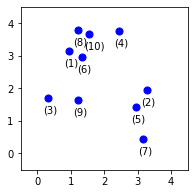

In [28]:
random10_4_cycles = towers(random10_4_arr, 25, adj_k=2)
random10_4_cycles.plant()
random10_4_cycles.grow()
random10_4_cycles.bnb_lin_drill_cycle(100,cycles=1)
print(f'min span: {random10_4_cycles.min_int_span}')
random10_4_cycles.plot_channels()

min span: 14


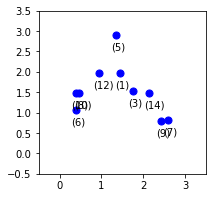

In [29]:
random10_3_arr = randomxy(10,3,3)
random10_3_drill = towers(random10_3_arr, 25, adj_k=2)
random10_3_drill.plant()
random10_3_drill.grow()
random10_3_drill.bnb_drill(1000)
print(f'min span: {random10_3_drill.min_int_span}')
random10_3_drill.plot_channels()

min span: 14


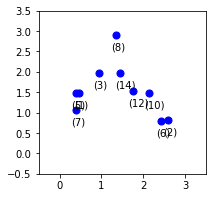

In [30]:
random10_3_cycles = towers(random10_3_arr, 25, adj_k=2)
random10_3_cycles.plant()
random10_3_cycles.grow()
random10_3_cycles.bnb_lin_drill_cycle(100,cycles=1)
print(f'min span: {random10_3_cycles.min_int_span}')
random10_3_cycles.plot_channels()

In [31]:
hex3_k2 = towers(abtoxy(hextoab(3)), 20, adj_k=2)
hex3_k2.plant()
hex3_k2.grow()
hex3_k2.Aub.shape

(8040, 740)